Compare Condensability score and C-half

In [27]:
# python modules
import sys
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [28]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [29]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [30]:
# 4-parameter logistic function (sigmoid type)
def sigmoid_func (x, top, rate, chalf, bottom):
    y = bottom + float(top-bottom)/(1+np.exp(rate*(x-chalf)))
    return y

# 4-parameter logistic function (Hill type)
def hill_func (x, top, rate, chalf, bottom):
    y = bottom + float(top-bottom)/(1.0 + (x/float(chalf))**rate)
    return y

# compute the CP value of logistic function
def get_CP (rate, chalf, percent, model='sigmoid'):
    surv_frac = 1 - percent/100.0
    ratio = float(1.0 - surv_frac)/surv_frac
    if model == 'sigmoid':
        CP = np.log(ratio)/float(rate) + chalf
    elif model == 'hill':
        CP = ((ratio)**(1.0/rate)) * chalf
    return CP

In [31]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [32]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}

In [33]:
### load gtab file
gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dinfo_dkey = {'H1_NCP_sp_1rep_10kb_sigmoid_4PL.gtab.gz':
              {'C-half':(1, 'H1', 'C-half')},
              'H1_NCP_sp_2rep_10kb_sigmoid_4PL.gtab.gz':
              {'C-half':(2, 'H1', 'C-half')},
              'H1_NCP_sp_1rep_10kb_score.gtab.gz':
              {'H1_NCP_sp_8_1rep':(1, 'H1', 'score')},
              'H1_NCP_sp_2rep_10kb_score.gtab.gz':
              {'H1_NCP_sp_8_2rep':(2, 'H1', 'score')},
              'GM_NCP_sp_1rep_10kb_sigmoid_4PL.gtab.gz':
              {'C-half':(1, 'GM', 'C-half')},
              'GM_NCP_sp_2rep_10kb_sigmoid_4PL.gtab.gz':
              {'C-half':(2, 'GM', 'C-half')},
              'GM_NCP_sp_1rep_10kb_score.gtab.gz':
              {'GM_NCP_sp_8_1rep':(1, 'GM', 'score')},
              'GM_NCP_sp_2rep_10kb_score.gtab.gz':
              {'GM_NCP_sp_8_2rep':(2, 'GM', 'score')},
              }

dkey_ID_value = load_file.read_gtab_batch (dinfo_dkey,
                                           data_path=gtab_path)

dkey_list = [(1, 'H1', 'C-half'),
             (2, 'H1', 'C-half'),
             (1, 'H1', 'score'),
             (2, 'H1', 'score'),
             (1, 'GM', 'C-half'),
             (2, 'GM', 'C-half'),
             (1, 'GM', 'score'),
             (2, 'GM', 'score')]


loading H1_NCP_sp_2rep_10kb_sigmoid_4PL.gtab.gz


loading GM_NCP_sp_1rep_10kb_score.gtab.gz


loading GM_NCP_sp_2rep_10kb_score.gtab.gz


loading H1_NCP_sp_2rep_10kb_score.gtab.gz


loading H1_NCP_sp_1rep_10kb_score.gtab.gz


loading GM_NCP_sp_2rep_10kb_sigmoid_4PL.gtab.gz


loading GM_NCP_sp_1rep_10kb_sigmoid_4PL.gtab.gz


loading H1_NCP_sp_1rep_10kb_sigmoid_4PL.gtab.gz


Done


In [34]:
### get common IDs
ID_list = set([])
for i in range(len(dkey_list)):
    dkey = dkey_list[i]
    if i == 0:
        ID_list |= set(dkey_ID_value[dkey].keys())
        continue
    ID_list &= set(dkey_ID_value[dkey].keys())
ID_list = sorted(list(ID_list))


In [35]:
### reorganize data and make labels
dkey_label = {}
dkey_data = {}
for dkey in dkey_list:
    rep, cell, metric = dkey
    label = "%s %s \n %d-rep" % (cell, metric, rep) 
    dkey_label[dkey] = label
    data = [dkey_ID_value[dkey][ID] for ID in ID_list]
    dkey_data[dkey] = data

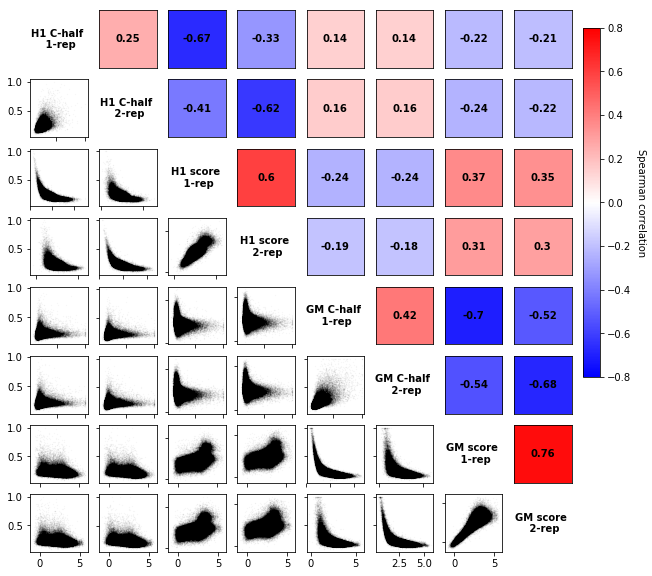

In [37]:
### plot correlation matrix between experiment
graphics.plot_corr_matrix(dkey_data,
                          dkey_label,
                          ids = dkey_list,
                          scatter_style='dot',
                          cmap='bwr',
                          ms=0.5,
                          fig_scale=0.8,
                          alpha=0.05,
                          vmin=-0.8,
                          vmax=0.8,
                          cbar=True,
                          save=False,
                          note='agent_corr')